In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/CancerMama

/content/drive/MyDrive/CancerMama


In [3]:
!ls

breast-cancer-classification-using-cnn.ipynb  Cancer-mama-tumor  kaggle.json


In [4]:
%cd Cancer-mama-tumor/

/content/drive/MyDrive/CancerMama/Cancer-mama-tumor


In [5]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
print('Done')

Done


In [6]:
# Proporciona funciones para interactuar con el sistema operativo, como la manipulación de archivos y directorios
import os

# Establece la ruta con el directorio que contiene el conjunto de datos
dataset_path = "/content/drive/MyDrive/CancerMama/Cancer-mama-tumor/Dataset_BUSI_with_GT/"

# Obtiene una lista de las imagenes.
image_files = []
labels = []

# Itera sobre las clases ('benign', 'malignant', 'normal') y recorre los archivos en el directorio correspondientes
for class_name in ['benign', 'malignant', 'normal']:
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image_files.append(image_path)
        labels.append(class_name)

# Convierte etiquetas a valores numéricos
from tensorflow.keras.utils import to_categorical

# Usa LabelEncoder para convertir las etiquetas de clase a valores numéricos.
# Guarda las clases originales en original_labels.
# Aplica one-hot encoding a las etiquetas utilizando to_categorical.
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
original_labels = label_encoder.classes_
labels = to_categorical(labels)


# Imprime el mapeo entre los valores numéricos asignados a las clases y las etiquetas originales.
for numerical_value, original_label in enumerate(original_labels):
    print(f"Numerical Value: {numerical_value}, Original Label: {original_label}")

print('Done')

Numerical Value: 0, Original Label: benign
Numerical Value: 1, Original Label: malignant
Numerical Value: 2, Original Label: normal
Done


In [7]:
print(labels.shape)
print(len(image_files))

(1578, 3)
1578


In [8]:
X_train, X_test, y_train, y_test = train_test_split(image_files, labels, test_size=0.3, random_state=42, stratify=labels)
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

1104 1104
474 474


In [9]:
# La función load_preprocess_image, toma la ruta de una imagen como entrada.
def load_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((150, 150))
# Convierte la imagen a blanco y negro
    image = image.convert('L')
    image = np.array(image)
    image = image.reshape((150, 150, 1))

# Convierte los valores de píxeles de la imagen al tipo de dato de punto flotante de 32 bits
# Divide cada valor de píxel por 255.0 para normalizar los valores de píxeles para que estén en el rango de [0, 1].
    image = image.astype('float32') / 255.0
    return image

# Convierte las rutas de las imágenes en listas X_train y X_test a cadenas.
X_train = [str(image_path) for image_path in X_train]
X_test = [str(image_path) for image_path in X_test]

# Convierte la lista resultante a un array numpy y lo asigna a X_train.
# Convierte las etiquetas de entrenamiento a un array numpy y lo asigna a y_train.
X_train = [load_preprocess_image(image_path) for image_path in X_train]
X_train = np.array(X_train)
y_train= np.array(y_train)

# Convierte la lista resultante a un array numpy y lo asigna a X_test.
# Convierte las etiquetas de prueba a un array numpy y lo asigna a y_test.
X_test= [load_preprocess_image(image_path) for image_path in X_test]
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# Proporciona información sobre la cantidad de imágenes y sus dimensiones
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

# Muestra las imagenes
images = X_test[:10]  # Supone que X_test contiene los datos de imagen
labels = y_test[:10]  # Supone que y_test contiene las etiquetas correspondientes

# Los convierte a indices de clases
class_indices = np.argmax(labels, axis=1)

# Define las etiquetas de clase
class_labels = ['Benign', 'Malignant', 'Normal']

num_rows = 2
num_cols = len(images) // num_rows

# Crea una red de subtramas
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Aplana la matriz de ejes para facilitar la indexación
axes = axes.flatten()

# Muestra imagenes con etiquetas en las subtramas
for i in range(len(images)):
    ax = axes[i]
    ax.imshow(images[i], cmap='gray')  # Supone que la imagen es 2D en escala de grises
    ax.set_title(f'True Label: {class_labels[class_indices[i]]}')
    ax.axis('off')

# Ajusta el diseño para tener un mayor espacio
plt.tight_layout()
plt.show()

In [14]:
# Inicializa el modelo
model = Sequential()

# Agrega capas convencionales
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Agrega más capas convencionales
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplana la salida
model.add(Flatten())

# Agrega capas mas densas
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compila el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define el llamado de EarlyStopping a la precision del monitor
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

# Entrena el modelo
#model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
16/16 [==============================] - 5s 180ms/step - loss: 0.9563 - accuracy: 0.5257 - val_loss: 0.7875 - val_accuracy: 0.5766
Epoch 2/20
16/16 [==============================] - 1s 44ms/step - loss: 0.8168 - accuracy: 0.5901 - val_loss: 0.7847 - val_accuracy: 0.5946
Epoch 3/20
16/16 [==============================] - 1s 44ms/step - loss: 0.7712 - accuracy: 0.6213 - val_loss: 0.7694 - val_accuracy: 0.6667
Epoch 4/20
16/16 [==============================] - 1s 43ms/step - loss: 0.7200 - accuracy: 0.7029 - val_loss: 0.7318 - val_accuracy: 0.6667
Epoch 5/20
16/16 [==============================] - 1s 43ms/step - loss: 0.6182 - accuracy: 0.7130 - val_loss: 0.6650 - val_accuracy: 0.6937
Epoch 6/20
16/16 [==============================] - 1s 43ms/step - loss: 0.5090 - accuracy: 0.7774 - val_loss: 0.7243 - val_accuracy: 0.6667
Epoch 7/20
16/16 [==============================] - 1s 44ms/step - loss: 0.4348 - accuracy: 0.8097 - val_loss: 0.6496 - val_accuracy: 0.7117
Epoch 8/20
1

In [15]:
# Evalúa el modelo en los conjuntos de entrenamiento
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Muestra la prueba del entrenamiento
print('Training Accuracy:', train_accuracy,"Train loss",train_loss)
print('Testing Accuracy:', test_accuracy,"Test Loss",test_loss)

Training Accuracy: 0.9728260636329651 Train loss 0.2519092261791229
Testing Accuracy: 0.8080168962478638 Test Loss 1.5158698558807373


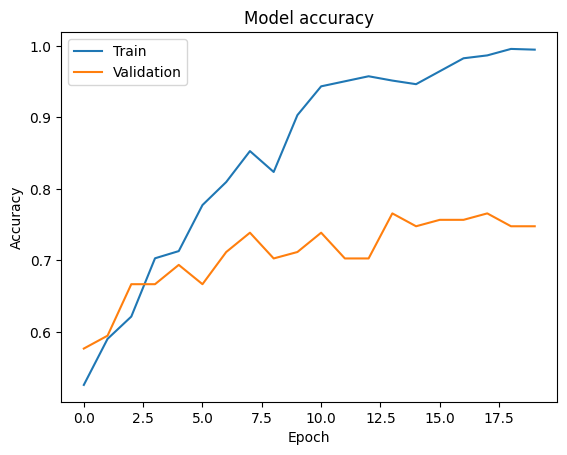

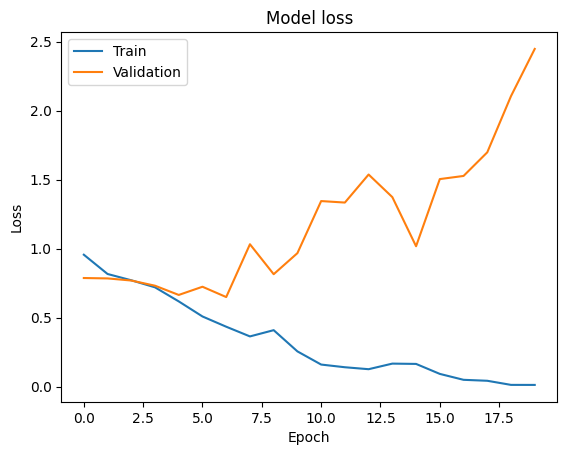

In [16]:
# Grafica de precision del modelo
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Grafica de entrenamiento y perdida del modelo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 17ms/step


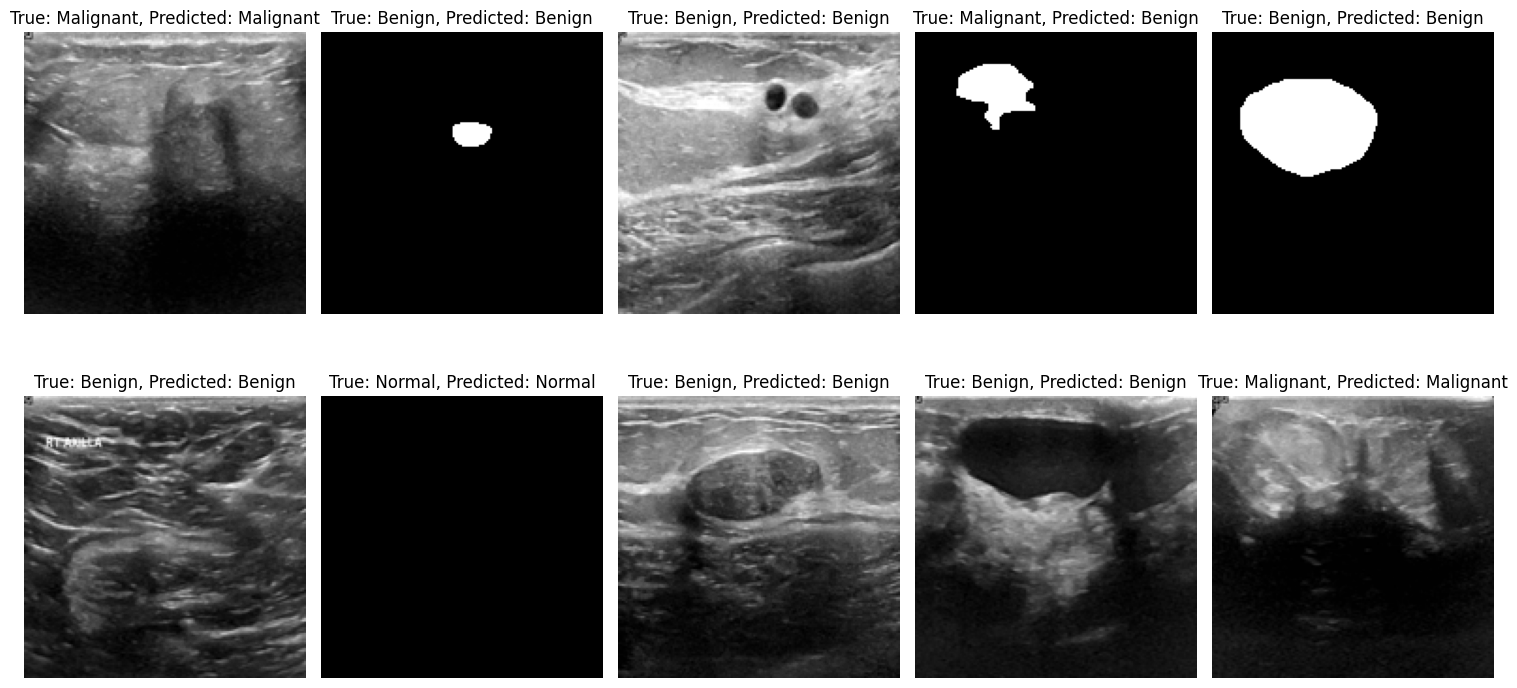

In [17]:
num_images_to_display = 10
selected_indices = np.random.choice(len(X_test), num_images_to_display, replace=False)
class_names = ['Benign', 'Malignant', 'Normal']
# Crea una red de subtramas
num_rows = 2
num_cols = num_images_to_display // num_rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Aplana la matriz de ejes para facilitar la indexación
axes = axes.flatten()

# Muestra predicciones para las imágenes de prueba seleccionadas.
for i, index in enumerate(selected_indices):
    # Obtiene la imagen de prueba y las etiquetas correctas
    test_image = X_test[index]
    true_label = np.argmax(y_test[index])

    # Procesa las imagenes
    img_array = np.expand_dims(test_image, axis=0)

    # Hace una predicción
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Muestra la imagen
    ax = axes[i]
    ax.imshow(test_image.reshape((150, 150)), cmap='gray')
    ax.set_title(f'True: {class_names[true_label]}, Predicted: {class_names[predicted_class]}')
    ax.axis('off')

# Ajusta el diseño para un mejor espaciado
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 18ms/step


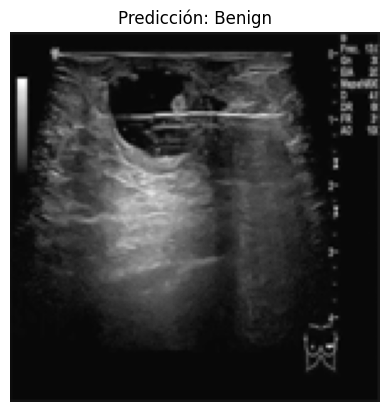

In [18]:
import requests
from io import BytesIO
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define la URL de la imagen que deseas probar
image_url = "https://diplomadomedico.com/wp-content/uploads/2018/05/adenoma-17.png"
#image_url = "https://www.piper.espacio-seram.com/public/journals/1/article_703_cover_es_ES.jpg"

# Descarga la imagen desde la URL
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = img.resize((150, 150))

# Convierte la imagen a escala de grises y realiza el preprocesamiento
img = img.convert('L')
img_array = np.array(img).reshape((1, 150, 150, 1))
img_array = img_array.astype('float32') / 255.0

# Realiza la predicción usando el modelo entrenado
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Mapea la clase predicha al nombre de la clase original
class_names = ['Benign', 'Malignant', 'Normal']
predicted_label = class_names[predicted_class]

# Muestra la imagen y la predicción
plt.imshow(np.array(img).reshape((150, 150)), cmap='gray')
plt.title(f'Predicción: {predicted_label}')
plt.axis('off')
plt.show()
